In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lcl_temp
from isca_tools.convection.base import dry_profile_temp, moist_profile, convection_neutral_profile
from isca_tools.utils.moist_physics import rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, mixing_ratio_from_partial_pressure, moist_static_energy, sphum_sat
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy.stats import percentileofscore
from scipy import interpolate
from geocat.comp.interpolation import interp_hybrid_to_pressure

In [2]:
ds_hours = isca_tools.load_dataset('rossbypalooza/depth=20/all_nh/lat_10/column/base_6_hours',
                        decode_times=True).isel(lon=0)

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [3]:
ds_hours['mse_surf'] = moist_static_energy(ds_hours.temp, ds_hours.sphum, ds_hours.height).sel(pfull=np.inf, method='nearest')
ds_hours['mse_sat'] = moist_static_energy(ds_hours.temp, sphum_sat(ds_hours.temp, ds_hours.pfull*100), ds_hours.height)

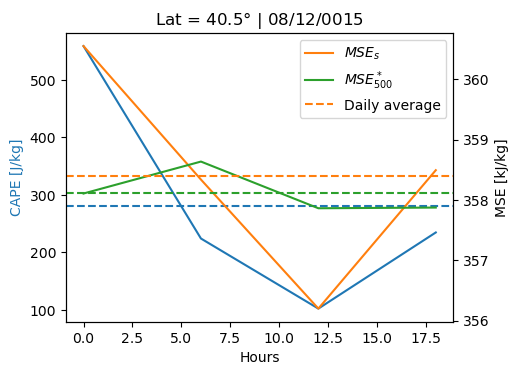

In [4]:
ds_use = ds_hours.sel(time='0015-08-12').sel(lat=40, method='nearest')
ds_use_av = ds_use.mean(dim='time')
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
ax.plot(ds_use.cape.time.dt.hour, ds_use.cape)
ax.axhline(ds_use_av.cape, color='C0', linestyle='--')
ax2 = ax.twinx()
ax2.plot(ds_use.cape.time.dt.hour, ds_use.mse_surf, color='C1', label='$MSE_{s}$')
ax2.plot(ds_use.cape.time.dt.hour, ds_use.mse_sat.sel(pfull=500, method='nearest'), color='C2', label='$MSE^*_{500}$')
ax2.axhline(moist_static_energy(ds_use_av.temp, ds_use_av.sphum, ds_use_av.height).sel(pfull=np.inf, method='nearest'),
            color='C1', linestyle='--', label='Daily average')
ax2.axhline(moist_static_energy(ds_use_av.temp, sphum_sat(ds_use_av.temp, ds_use_av.pfull*100), ds_use_av.height).sel(pfull=500, method='nearest'),
            color='C2', linestyle='--')
ax.set_ylabel('CAPE [J/kg]', color='C0')
ax2.set_ylabel('MSE [kJ/kg]')
ax2.legend()
ax.set_title(f"Lat = {ds_use.lat:.1f}$\degree$ | {ds_use.time.dt.strftime('%m/%d/%Y')[0].values}")
ax.set_xlabel('Hours')
plt.show()